<h1 style="font-size:300%">ANIMAL SOUND CLASSIFIER</h1>

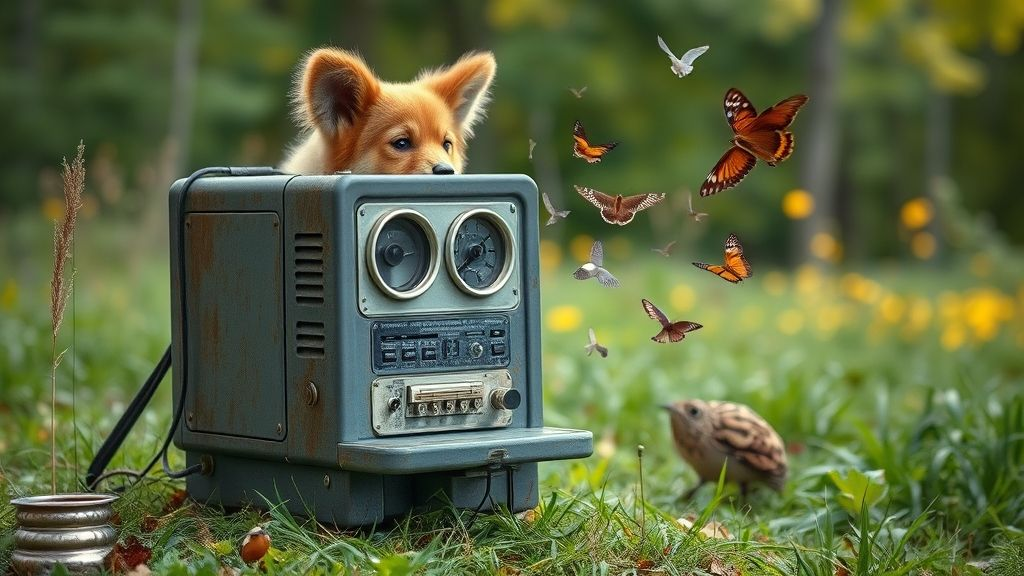

In [10]:
import librosa, os, pandas, platform, torch

import lightning as L
import torch.utils.data as D
import torch.nn.functional as F
import torchmetrics as M

torch.manual_seed(42)

data_path = "data"
sample_length = 200

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| lightning", L.__version__, "| librosa", librosa.__version__)

Versions: python 3.10.11 | torch 2.7.0+cu128 | lightning 2.5.1.post0 | librosa 0.11.0


In [11]:
class AudioDataset(D.Dataset):
    def __init__(self, path, sample_length=50):
        self.sample_length = sample_length
        self.files = []
        self.labels = []
        self.classes = os.listdir(path)
        self.n_mfcc = 13
        for label in self.classes:
            class_dir = os.path.join(path, label)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.wav'):
                        self.files.append(os.path.join(class_dir, file))
                        self.labels.append(self.classes.index(label))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        audio_path = self.files[index]
        label = self.labels[index]
        audio, _ = librosa.load(audio_path)
        mfcc = librosa.feature.mfcc(y=audio, n_mfcc=self.n_mfcc)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        if mfcc_tensor.shape[1] < self.sample_length: # Pad with zeros
            padding = (0, self.sample_length - mfcc_tensor.shape[1])
            mfcc_tensor = F.pad(mfcc_tensor, padding, mode='constant', value=0)
        else: # Truncate
            mfcc_tensor = mfcc_tensor[:, :self.sample_length]
        return mfcc_tensor, label

    def num_classes(self):
        return len(self.classes)
    
    def num_features(self):
        return self.n_mfcc
    
dataset = AudioDataset(data_path, sample_length)
print("Created a DataSet with", len(dataset), "items for the following classes:", dataset.classes)

Created a DataSet with 205 items for the following classes: ['chicken', 'cow', 'donkey', 'frog', 'sheep']


# Sample the data

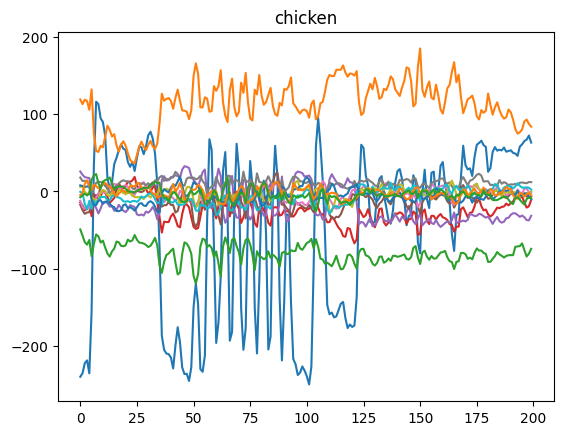

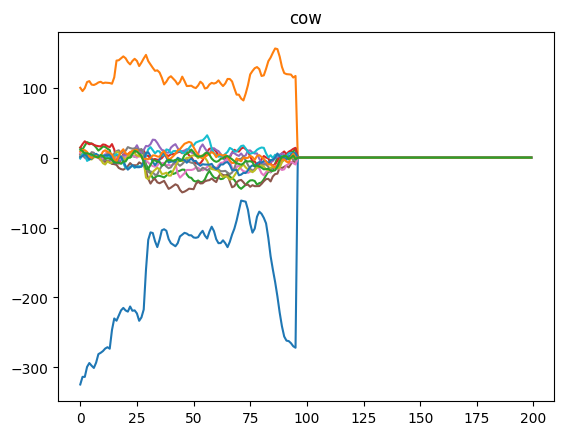

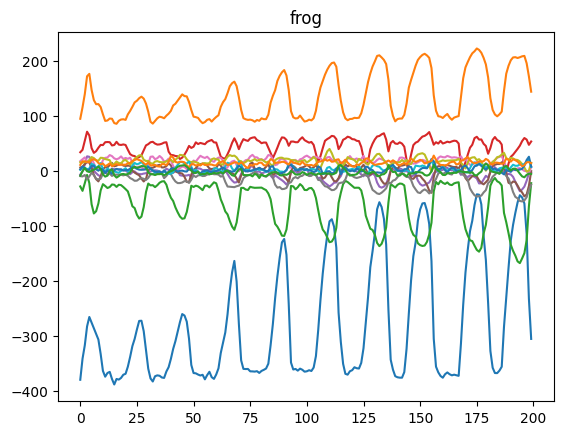

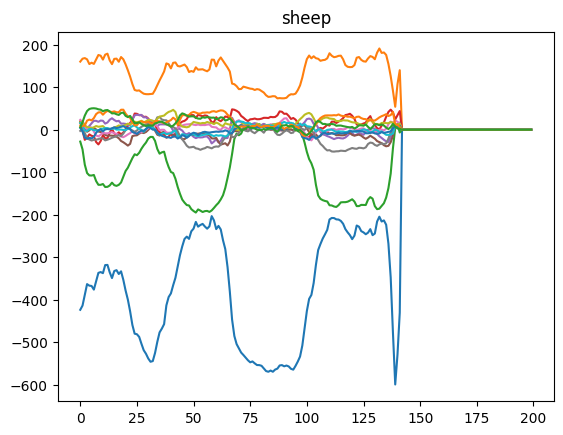

In [12]:
for data in [dataset[0], dataset[45], dataset[150], dataset[200]]:
    plot = pandas.DataFrame(torch.t(data[0])).plot(legend=None, title=dataset.classes[data[1]])

In [13]:
train, val, test = D.random_split(dataset, [.5, .3, .2])
datamodule = L.LightningDataModule.from_datasets(train, val, test, batch_size=32, num_workers=0)
print("Created a DataModule with:", len(datamodule.train_dataloader().dataset), "training items,", len(datamodule.val_dataloader().dataset), "validation items and", len(datamodule.test_dataloader().dataset), "test items.")

Created a DataModule with: 103 training items, 61 validation items and 41 test items.


In [14]:
from torch import nn

class AudioClassifier(L.LightningModule):
    def __init__(self, num_classes, num_features, sample_length):
        super().__init__()
        self.num_classes = num_classes
        pool_stride = 2
        self.model = nn.Sequential(
            nn.Conv1d(num_features, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=pool_stride),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=pool_stride),
            nn.Flatten(),
            nn.Linear(64 * (sample_length // pool_stride // pool_stride), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = M.Accuracy(task="multiclass", num_classes=num_classes, average="none")
        self.precision = M.Precision(task="multiclass", num_classes=num_classes, average="none")
        self.recall = M.Recall(task="multiclass", num_classes=num_classes, average="none")

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.criterion(logits, y))
    
    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

model = AudioClassifier(dataset.num_classes(), dataset.num_features(), sample_length)

# Train

Now, let's use the PyTorch Lightning Trainer to train the model with our Data Module. Rather than telling it beforehand how many epochs to train, we use an EarlyStopping callback that stops the training process when the model has reached convergence. Information is logged to a CSV logger that can be used after training to provide evaluation metrics.

In [15]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
trainer = L.Trainer(logger=logger, max_epochs=-1, callbacks=[stop])
trainer.fit(model, datamodule=datamodule)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | Sequential          | 828 K  | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.313     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 330.65it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Bas\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s, v_num=1]


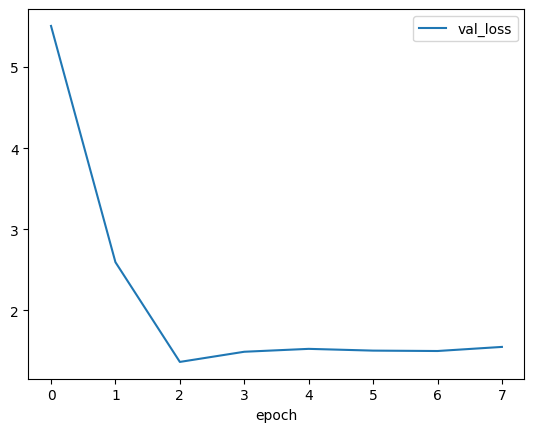

In [16]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

# Test

Here we use the Trainer to run the model against the test data and collect the evaluation metrics.

In [47]:
scores = trainer.test(model, datamodule=datamodule, verbose=False)
subset = datamodule.test_dataloader().dataset
_, counts = torch.unique(torch.tensor([subset.dataset[i][1] for i in subset.indices], dtype=torch.long), return_counts=True)
accuracies = [round(scores[0]["test_accuracy_class_" + str(i)],2) for i in range(len(dataset.classes))]
precisions = [round(scores[0]["test_precision_class_" + str(i)],2) for i in range(len(dataset.classes))]
recalls = [round(scores[0]["test_recall_class_" + str(i)],2) for i in range(len(dataset.classes))]
df = pandas.DataFrame({"Class": dataset.classes, "Support": counts.numpy(), "Accuracy": accuracies, "Precision": precisions, "Recall": recalls}).set_index("Class")
df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Bas\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 30.11it/s] 


,Support,Accuracy,Precision,Recall
Class,,,,
chicken,5,0.60,0.75,0.60
cow,14,0.71,0.83,0.71
donkey,4,0.75,1.00,0.75
frog,7,0.86,0.43,0.86
sheep,11,0.45,0.62,0.45


In [68]:
test_dataloader = datamodule.test_dataloader()
files = [dataset.files[i] for i in test_dataloader.dataset.indices]
preds = trainer.predict(model, dataloaders=test_dataloader)
predictions = torch.cat(preds)
labels = torch.cat([y for x, y in test_dataloader])
results = []
for i, (file, truth, prediction) in enumerate(zip(files, labels, predictions)):
    probabilities = torch.softmax(prediction, dim=0)
    pred_class = torch.argmax(probabilities)
    probabilities = [round(float(p), 2) for p in torch.softmax(prediction, dim=0).detach().numpy()]
    prediction_label = dataset.classes[pred_class] + " " + ("✅" if dataset.classes[truth] == dataset.classes[pred_class] else "❌")
    result = [file, dataset.classes[truth], prediction_label] + probabilities
    results.append(result)
df = pandas.DataFrame(results, columns=["File", "Truth", "Prediction"] + dataset.classes)
df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Bas\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s] 


,File,Truth,Prediction,chicken,cow,donkey,frog,sheep
0,data\donkey\esek_16.wav,donkey,donkey ✅,0.12,0.02,0.60,0.22,0.04
1,data\chicken\tavuk_8.wav,chicken,chicken ✅,0.92,0.03,0.03,0.02,0.00
2,data\chicken\tavuk_9.wav,chicken,frog ❌,0.16,0.00,0.05,0.76,0.02
3,data\cow\inek_55.wav,cow,cow ✅,0.00,0.48,0.39,0.12,0.02
4,data\sheep\koyun_20.wav,sheep,sheep ✅,0.00,0.02,0.00,0.00,0.98
5,data\sheep\koyun_18.wav,sheep,sheep ✅,0.00,0.00,0.00,0.11,0.88
6,data\cow\inek_72.wav,cow,cow ✅,0.00,0.92,0.00,0.04,0.03
7,data\sheep\koyun_24.wav,sheep,frog ❌,0.00,0.06,0.00,0.70,0.24
8,data\sheep\koyun_16.wav,sheep,frog ❌,0.14,0.04,0.09,0.61,0.12
9,data\sheep\koyun_27.wav,sheep,sheep ✅,0.00,0.00,0.00,0.00,1.00
